# import library


In [1]:
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set()

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(1234)

# Read Dataset

In [3]:
# df = pd.read_csv('https://raw.githubusercontent.com/christianbangarna/IDSL/main/IDSL-307_data.csv', parse_dates = ['Time(UTC)'], index_col = 'Time(UTC)') 
df = pd.read_csv('IDSL-307_data.csv', parse_dates = ['Time(UTC)'], index_col = 'Time(UTC)')
newinput = df[df.index>=dt.datetime(2021,5,1)].copy()
df = df[df.index<dt.datetime(2021,5,1)]
df

,Lev RAD (m),Panel (V),rms (m),Sensor Temp (C),Temperature (C),Alert,Alert Signal,Battery (V),Forecast 30 (m),Forecast 300 (m)
Time(UTC),,,,,,,,,,
2019-11-10 06:23:30,5.888,-5.5,0.034,58.5,61.771,0.0,0.042,12.767,5.919,5.961
2019-11-10 06:32:26,6.014,-5.5,0.025,59.1,62.409,0.0,0.036,12.758,6.018,5.982
2019-11-10 08:31:57,6.306,-5.5,0.032,60.7,66.684,0.0,0.041,12.742,6.317,6.277
2019-11-10 09:32:52,6.725,-5.5,0.028,59.1,61.838,0.0,0.081,12.651,6.655,6.575
2019-11-10 09:40:37,6.604,-5.5,0.027,59.1,60.341,0.0,0.002,12.582,6.602,6.601
...,...,...,...,...,...,...,...,...,...,...
2021-04-30 20:32:59,6.142,-5.5,0.049,51.5,-80.999,0.0,0.038,12.026,6.129,6.091
2021-04-30 21:16:24,6.072,-5.5,0.037,51.0,-80.999,0.0,0.003,11.999,6.057,6.055
2021-04-30 21:37:10,6.089,-5.5,0.044,51.5,-80.999,0.0,0.098,11.972,6.043,6.142


In [4]:
# Explore the first five rows
df.head()

,Lev RAD (m),Panel (V),rms (m),Sensor Temp (C),Temperature (C),Alert,Alert Signal,Battery (V),Forecast 30 (m),Forecast 300 (m)
Time(UTC),,,,,,,,,,
2019-11-10 06:23:30,5.888,-5.5,0.034,58.5,61.771,0.0,0.042,12.767,5.919,5.961
2019-11-10 06:32:26,6.014,-5.5,0.025,59.1,62.409,0.0,0.036,12.758,6.018,5.982
2019-11-10 08:31:57,6.306,-5.5,0.032,60.7,66.684,0.0,0.041,12.742,6.317,6.277
2019-11-10 09:32:52,6.725,-5.5,0.028,59.1,61.838,0.0,0.081,12.651,6.655,6.575
2019-11-10 09:40:37,6.604,-5.5,0.027,59.1,60.341,0.0,0.002,12.582,6.602,6.601


In [5]:
# Data description
df.describe()

,Lev RAD (m),Panel (V),rms (m),Sensor Temp (C),Temperature (C),Alert,Alert Signal,Battery (V),Forecast 30 (m),Forecast 300 (m)
count,19290.000000,19290.0,19290.000000,19290.000000,19290.000000,19290.000000,19290.000000,19290.000000,19290.000000,19290.000000
mean,6.689754,-5.5,0.037197,54.171058,-2.260389,0.002851,0.027869,12.453891,6.689191,6.689698
std,0.436836,0.0,0.062633,6.471291,65.272096,0.147708,0.030044,0.370125,0.433627,0.431866
min,5.511000,-5.5,0.000000,-1.000000,-80.999000,0.000000,0.000000,11.795000,5.365000,5.563000
25%,6.375000,-5.5,0.022000,51.500000,-80.999000,0.000000,0.009000,12.184000,6.374250,6.375000
50%,6.674000,-5.5,0.029000,53.700000,41.081000,0.000000,0.020000,12.316000,6.674000,6.672000
75%,7.010000,-5.5,0.040000,58.000000,49.498000,0.000000,0.037000,12.695000,7.011000,7.010000
max,10.707000,-5.5,2.652000,73.100000,88.542000,10.000000,0.812000,13.600000,8.105000,8.148000


In [6]:
# Find number of rows and columns
df.shape

(19290, 10)

# Time Series Plot

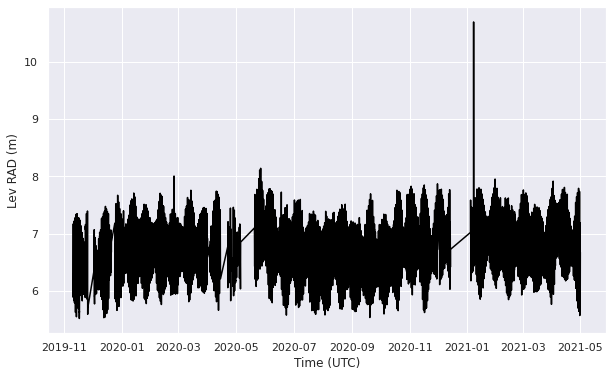

In [7]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12})
    plt.ylabel(y_label, {'fontsize': 12})

timeseries(df.index, df['Lev RAD (m)'], 'Time (UTC)', 
           'Lev RAD (m)')

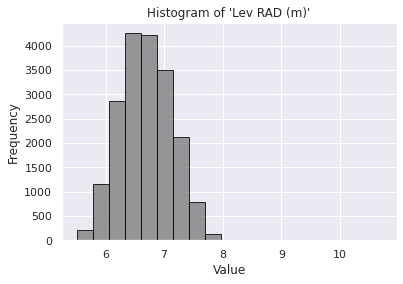

In [8]:
def plot_histogram(x):
    plt.hist(x, bins = 19, alpha=0.8, color = 'gray', edgecolor = 'black')
    plt.title("Histogram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plot_histogram(df['Lev RAD (m)'])

# Data Preprocessing

In [9]:
df = df.rename(columns = {'Lev RAD (m)':'RAD','Temperature (C)':'Temp', 'Sensor Temp (C)':'S_Temp', 
                          'rms (m)':'RMS','Forecast 30 (m)':'FC30'})

df

,RAD,Panel (V),RMS,S_Temp,Temp,Alert,Alert Signal,Battery (V),FC30,Forecast 300 (m)
Time(UTC),,,,,,,,,,
2019-11-10 06:23:30,5.888,-5.5,0.034,58.5,61.771,0.0,0.042,12.767,5.919,5.961
2019-11-10 06:32:26,6.014,-5.5,0.025,59.1,62.409,0.0,0.036,12.758,6.018,5.982
2019-11-10 08:31:57,6.306,-5.5,0.032,60.7,66.684,0.0,0.041,12.742,6.317,6.277
2019-11-10 09:32:52,6.725,-5.5,0.028,59.1,61.838,0.0,0.081,12.651,6.655,6.575
2019-11-10 09:40:37,6.604,-5.5,0.027,59.1,60.341,0.0,0.002,12.582,6.602,6.601
...,...,...,...,...,...,...,...,...,...,...
2021-04-30 20:32:59,6.142,-5.5,0.049,51.5,-80.999,0.0,0.038,12.026,6.129,6.091
2021-04-30 21:16:24,6.072,-5.5,0.037,51.0,-80.999,0.0,0.003,11.999,6.057,6.055
2021-04-30 21:37:10,6.089,-5.5,0.044,51.5,-80.999,0.0,0.098,11.972,6.043,6.142


In [10]:
# Check missing values
df.isnull().sum()

RAD                 0
Panel (V)           0
RMS                 0
S_Temp              0
Temp                0
Alert               0
Alert Signal        0
Battery (V)         0
FC30                0
Forecast 300 (m)    0
dtype: int64

In [11]:
# Replace missing values by interpolation
def replace_missing (attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df['RMS'])
replace_missing(df['S_Temp'])
replace_missing(df['Temp'])
replace_missing(df['FC30'])

In [12]:
# Outlier detection
up_b = df['RAD'].mean() + 2*df['RAD'].std()
low_b = df['RAD'].mean() - 2*df['RAD'].std()

# Replace outlier by interpolation for base consumption
df.loc[df['RAD'] > up_b, 'RAD'] = np.nan
df.loc[df['RAD'] < low_b, 'RAD'] = np.nan
df['RAD'].interpolate(inplace=True)

Dimension of train data:  (15432, 10)
Dimension of test data:  (3858, 10)


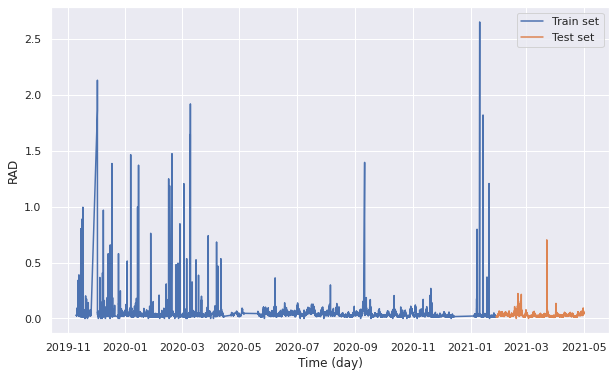

In [13]:
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.RMS)
plt.plot(test_dataset.RMS)
plt.xlabel('Time (day)')
plt.ylabel('RAD')
plt.legend(['Train set', 'Test set'], loc='upper right')

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)


In [14]:
# Split train data to X and y
X_train = train_dataset.drop('RAD', axis = 1)
y_train = train_dataset.loc[:,['RAD']]

# Split test data to X and y
X_test = test_dataset.drop('RAD', axis = 1)
y_test = test_dataset.loc[:,['RAD']]

In [15]:
# Transform X_train, y_train, X_test and y_test

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [16]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 30

X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape)

X_train.shape:  (3828, 30, 9)
y_train.shape:  (15402, 1)
X_test.shape:  (3828, 30, 9)
y_test.shape:  (15402, 1)


In [17]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Second layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Second layer of LSTM
    model.add(m (units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# BiLSTM
model_bilstm = create_model_bilstm(64)

# GRU and LSTM 
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

In [18]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

    # shuffle = False because the order of the data matters
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/100
386/386 [==============================] - 32s 61ms/step - loss: 0.0316 - val_loss: 0.0084
Epoch 2/100
386/386 [==============================] - 25s 64ms/step - loss: 0.0100 - val_loss: 0.0086
Epoch 3/100
386/386 [==============================] - 29s 76ms/step - loss: 0.0080 - val_loss: 0.0089
Epoch 4/100
386/386 [==============================] - 25s 66ms/step - loss: 0.0073 - val_loss: 0.0090
Epoch 5/100
386/386 [==============================] - 26s 66ms/step - loss: 0.0071 - val_loss: 0.0093
Epoch 6/100
386/386 [==============================] - 26s 67ms/step - loss: 0.0070 - val_loss: 0.0095
Epoch 7/100
386/386 [==============================] - 26s 66ms/step - loss: 0.0069 - val_loss: 0.0096
Epoch 8/100
386/386 [==============================] - 25s 66ms/step - loss: 0.0070 - val_loss: 0.0093
Epoch 9/100
386/386 [==============================] - 25s 66ms/step - loss: 0.0070 - val_loss: 0.0082
Epoch 10/100
386/386 [==============================] - 25s 66ms/step - l

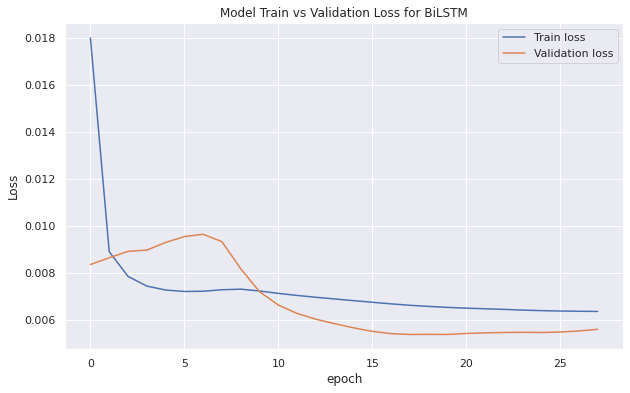

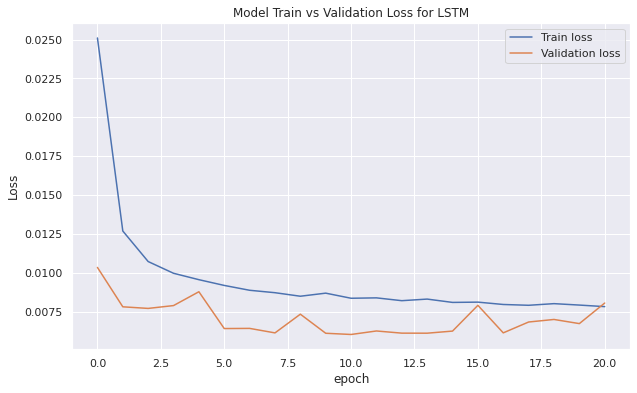

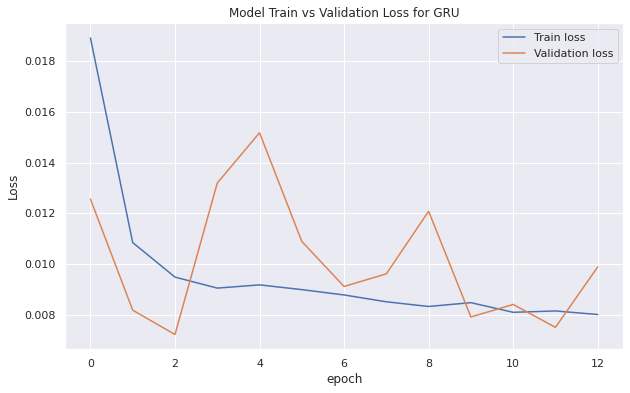

In [19]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_bilstm, 'BiLSTM')
plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')

In [20]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

# Prediction

In [21]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)


PLOT FUTUE PREDICTION

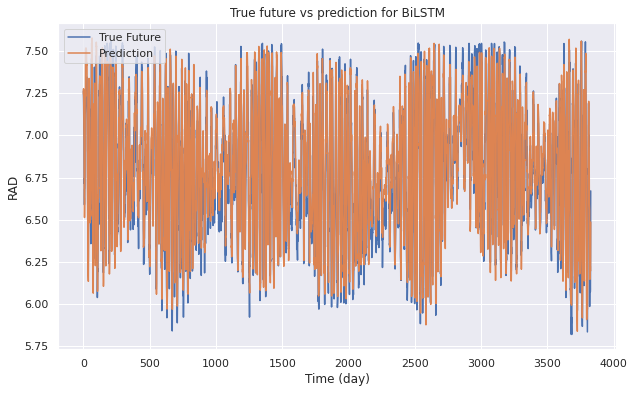

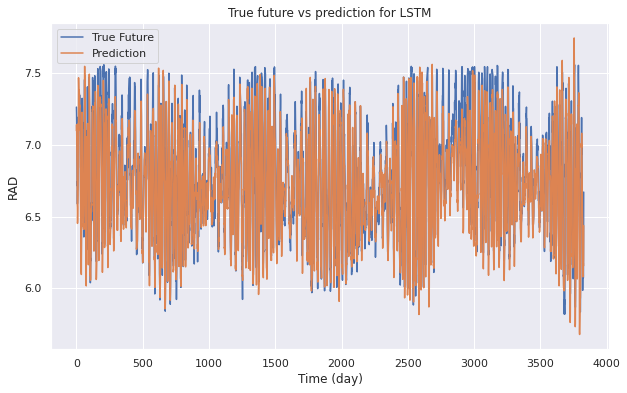

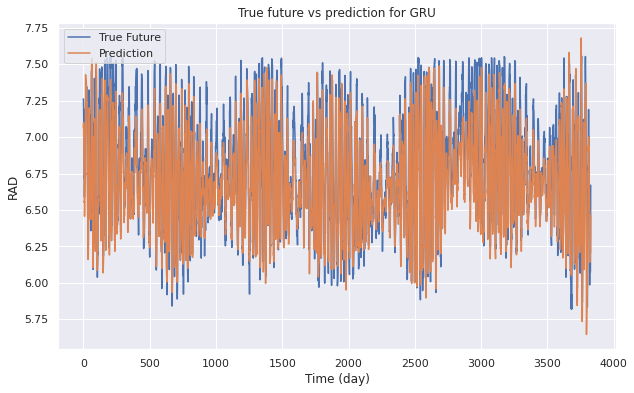

In [22]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('RAD')
    
    
plot_future(prediction_bilstm, 'BiLSTM', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)

In [23]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')


Bidirectional LSTM:
Mean Absolute Error: 0.1049
Root Mean Square Error: 0.1440

LSTM:
Mean Absolute Error: 0.1189
Root Mean Square Error: 0.1619

GRU:
Mean Absolute Error: 0.1339
Root Mean Square Error: 0.1750



FORECAST 10 YEARS

In [24]:
X_new = newinput.drop('Lev RAD (m)', axis = 1)
X_new

,Panel (V),rms (m),Sensor Temp (C),Temperature (C),Alert,Alert Signal,Battery (V),Forecast 30 (m),Forecast 300 (m)
Time(UTC),,,,,,,,,
2021-05-01 00:53:31,-5.5,0.044,55.3,-80.999,0.0,0.078,12.702,7.175,7.098
2021-05-01 02:25:06,-5.5,0.047,60.7,-80.999,0.0,0.052,13.263,7.569,7.516
2021-05-01 04:05:48,-5.5,0.048,62.3,-80.999,0.0,0.003,12.640,7.633,7.629
2021-05-01 04:09:28,-5.5,0.045,62.3,-80.999,0.0,0.024,12.640,7.606,7.630
2021-05-01 04:40:06,-5.5,0.031,61.8,-80.999,0.0,0.055,12.637,7.552,7.497
...,...,...,...,...,...,...,...,...,...
2021-07-15 20:58:46,-5.5,0.098,49.4,39.696,0.0,0.186,11.994,6.549,6.735
2021-07-15 22:47:44,-5.5,0.134,48.9,35.831,0.0,0.024,11.948,6.468,6.444
2021-07-17 23:03:15,-5.5,0.000,48.3,37.460,0.0,0.000,11.998,7.046,7.046


In [25]:
# Plot histoy and future data
def plot_history_future(y_train, prediction, model_name):
    
    plt.figure(figsize=(10, 6))
    
    range_history = len(y_train)
    range_future = list(range(range_history, range_history + len(prediction)))

    plt.plot(np.arange(range_history), np.array(y_train), label='History')
    plt.plot(range_future, np.array(prediction),label='Prediction')

    plt.title('History and prediction for ' + model_name)
    plt.legend(loc='upper right')
    plt.xlabel('Time (day)')
    plt.ylabel('RAD')

(851, 9)


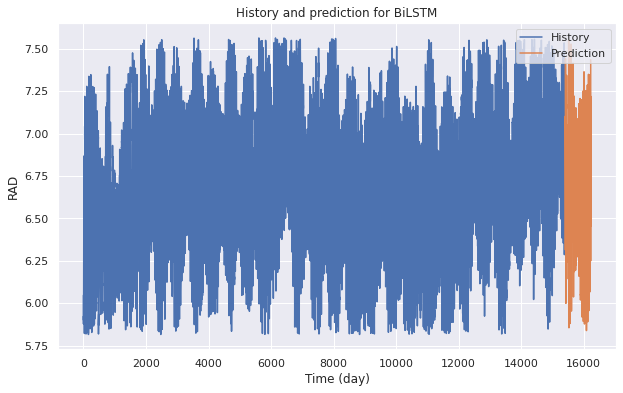

In [26]:
def forecast(X_input, time_steps):
    # Scale the unseen input with the scaler fitted on the training data
    X = input_scaler.transform(X_input)
    # Reshape unseen data to a 3D input
    Xs = []
    for i in range(len(X) - time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        
    X_transformed = np.array(Xs)

    # Make prediction for unseen data using LSTM model 
    prediction = model_bilstm.predict(X_transformed)
    prediction_actual = scaler_y.inverse_transform(prediction)
    return prediction_actual
testing = input_scaler.transform(X_new)
print(testing.shape)
prediction = forecast(X_new, TIME_STEPS)
plot_history_future(y_train, prediction,'BiLSTM')